In [1]:
# In[1]: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting defaults
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
# In[3]: Load the Datasets

# Example file paths (adjust as needed)
path_nh_citations = 'data/final-csv/nh_citations.csv'
path_nh_ownership = 'data/final-csv/nh_ownership.csv'
path_nh_quality_mds = 'data/final-csv/nh_quality_mds.csv'
path_nh_survey = 'data/final-csv/nh_survey.csv'
path_pbj_non_nurse = 'data/final-csv/pbj_non_nurse.csv'
path_pbj_nurse = 'data/final-csv/pbj_nurse.csv'
path_qrp_provider = 'data/final-csv/qrp_provider.csv'

# Read CSVs into DataFrames with low_memory=False
df_nh_citations = pd.read_csv(path_nh_citations, low_memory=False)
df_nh_ownership = pd.read_csv(path_nh_ownership, low_memory=False)
df_nh_quality_mds = pd.read_csv(path_nh_quality_mds, low_memory=False)
df_nh_survey = pd.read_csv(path_nh_survey, low_memory=False)
df_pbj_non_nurse = pd.read_csv(path_pbj_non_nurse, low_memory=False)
df_pbj_nurse = pd.read_csv(path_pbj_nurse, low_memory=False)
df_qrp_provider = pd.read_csv(path_qrp_provider, low_memory=False)

# Quick checks
print("nh_citations shape:", df_nh_citations.shape)
print("nh_ownership shape:", df_nh_ownership.shape)
print("nh_quality_mds shape:", df_nh_quality_mds.shape)
print("nh_survey shape:", df_nh_survey.shape)
print("pbj_non_nurse shape:", df_pbj_non_nurse.shape)
print("pbj_nurse shape:", df_pbj_nurse.shape)
print("qrp_provider shape:", df_qrp_provider.shape)


nh_citations shape: (406789, 23)
nh_ownership shape: (144651, 13)
nh_quality_mds shape: (251464, 23)
nh_survey shape: (44189, 41)
pbj_non_nurse shape: (1325324, 82)
pbj_nurse shape: (1325324, 33)
qrp_provider shape: (710016, 16)


In [3]:
# In[5]: Basic Exploration of Each Dataset

# Example: checking columns, dtypes, a few rows
for name, df in [
    ("nh_citations", df_nh_citations),
    ("nh_ownership", df_nh_ownership),
    ("nh_quality_mds", df_nh_quality_mds),
    ("nh_survey", df_nh_survey),
    ("pbj_non_nurse", df_pbj_non_nurse),
    ("pbj_nurse", df_pbj_nurse),
    ("qrp_provider", df_qrp_provider)
]:
    print(f"\n--- {name} ---")
    print("Columns:", df.columns.tolist())
    print("Data Types:\n", df.dtypes)
    print("Sample Rows:\n", df.head(3))



--- nh_citations ---
Columns: ['cms_certification_number_(ccn)', 'provider_name', 'provider_address', 'city/town', 'state', 'zip_code', 'survey_date', 'survey_type', 'deficiency_prefix', 'deficiency_category', 'deficiency_tag_number', 'deficiency_description', 'scope_severity_code', 'deficiency_corrected', 'correction_date', 'inspection_cycle', 'standard_deficiency', 'complaint_deficiency', 'infection_control_inspection_deficiency', 'citation_under_idr', 'citation_under_iidr', 'location', 'processing_date']
Data Types:
 cms_certification_number_(ccn)             object
provider_name                              object
provider_address                           object
city/town                                  object
state                                      object
zip_code                                    int64
survey_date                                object
survey_type                                object
deficiency_prefix                          object
deficiency_category    

In [4]:
import pandas as pd
import numpy as np
from scipy import stats

# Ensure workdate is datetime
df_pbj_nurse['workdate'] = pd.to_datetime(df_pbj_nurse['workdate'])
df_pbj_non_nurse['workdate'] = pd.to_datetime(df_pbj_non_nurse['workdate'])

# 1. Daily Temporary Staffing Ratios for Each Role
# Nursing Roles
daily_ratios = pd.DataFrame()

# RN Daily Ratio
daily_ratios['rn_daily_ratio'] = (df_pbj_nurse['hrs_rn_ctr'] / 
                                 (df_pbj_nurse['hrs_rn_emp'] + df_pbj_nurse['hrs_rn_ctr'] + 1e-6))

# LPN Daily Ratio
daily_ratios['lpn_daily_ratio'] = (df_pbj_nurse['hrs_lpn_ctr'] / 
                                  (df_pbj_nurse['hrs_lpn_emp'] + df_pbj_nurse['hrs_lpn_ctr'] + 1e-6))

# CNA Daily Ratio
daily_ratios['cna_daily_ratio'] = (df_pbj_nurse['hrs_cna_ctr'] / 
                                  (df_pbj_nurse['hrs_cna_emp'] + df_pbj_nurse['hrs_cna_ctr'] + 1e-6))

# Support Roles (Non-Nursing) Daily Ratio
contract_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_ctr')]
employee_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_emp')]

daily_ratios['support_daily_ratio'] = (
    df_pbj_non_nurse[contract_cols].sum(axis=1) /
    (df_pbj_non_nurse[contract_cols].sum(axis=1) + df_pbj_non_nurse[employee_cols].sum(axis=1) + 1e-6)
)

# Add workdate and facility identifier
daily_ratios['workdate'] = df_pbj_nurse['workdate']
daily_ratios['provnum'] = df_pbj_nurse['provnum']

# 2. Variation Metrics
# Calculate standard deviation for each facility
variation_metrics = daily_ratios.groupby('provnum').agg({
    'rn_daily_ratio': ['mean', 'std'],
    'lpn_daily_ratio': ['mean', 'std'],
    'cna_daily_ratio': ['mean', 'std'],
    'support_daily_ratio': ['mean', 'std']
}).round(4)

# Calculate 7-day moving averages for trend analysis
daily_facility_ratios = daily_ratios.set_index('workdate')
rolling_means = daily_facility_ratios.groupby('provnum').rolling(window=7, min_periods=1).mean()

# 3. Gap Identification (using k=2 for threshold)
k = 2  # Standard deviations above mean to identify gaps

# Calculate facility-specific means and standard deviations
facility_stats = daily_ratios.groupby('provnum').agg({
    'rn_daily_ratio': ['mean', 'std'],
    'lpn_daily_ratio': ['mean', 'std'],
    'cna_daily_ratio': ['mean', 'std'],
    'support_daily_ratio': ['mean', 'std']
})

# Function to identify gaps for a given ratio
def identify_gaps(group, stat_df, role, k=2):
    facility_mean = stat_df.loc[group.name, (role, 'mean')]
    facility_std = stat_df.loc[group.name, (role, 'std')]
    threshold = facility_mean + (k * facility_std)
    return group[role] > threshold

# Create gap indicators for each role
gap_indicators = pd.DataFrame()
for role in ['rn_daily_ratio', 'lpn_daily_ratio', 'cna_daily_ratio', 'support_daily_ratio']:
    gaps = daily_ratios.groupby('provnum').apply(
        lambda x: identify_gaps(x, facility_stats, role, k)
    ).reset_index(level=0, drop=True)
    gap_indicators[f'{role}_gap'] = gaps.astype(int)

# Add dates and facility identifiers to gap indicators
gap_indicators['workdate'] = daily_ratios['workdate']
gap_indicators['provnum'] = daily_ratios['provnum']

# Summary statistics
print("\nVariation Metrics Summary (first 5 facilities):")
print(variation_metrics.head())

print("\nGap Summary (percentage of days with staffing gaps by role):")
gap_summary = gap_indicators.iloc[:, :-2].mean() * 100
print(gap_summary)

# Time series patterns
print("\nDay-of-Week Patterns (average ratios):")
daily_ratios['day_of_week'] = daily_ratios['workdate'].dt.day_name()
dow_patterns = daily_ratios.groupby('day_of_week')[
    ['rn_daily_ratio', 'lpn_daily_ratio', 'cna_daily_ratio', 'support_daily_ratio']
].mean()
print(dow_patterns)

C:\Users\paulo\AppData\Local\Temp\ipykernel_44928\3704180892.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = daily_ratios.groupby('provnum').apply(
C:\Users\paulo\AppData\Local\Temp\ipykernel_44928\3704180892.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = daily_ratios.groupby('provnum').apply(
C:\Users\paulo\AppData\Local\Temp\ipykernel_44928\3704180892.py:72: DeprecationWarning: Da


Variation Metrics Summary (first 5 facilities):
        rn_daily_ratio      lpn_daily_ratio      cna_daily_ratio       \
                  mean  std            mean  std            mean  std   
provnum                                                                 
015009             0.0  0.0             0.0  0.0             0.0  0.0   
015010             0.0  0.0             0.0  0.0             0.0  0.0   
015012             0.0  0.0             0.0  0.0             0.0  0.0   
015014             0.0  0.0             0.0  0.0             0.0  0.0   
015015             0.0  0.0             0.0  0.0             0.0  0.0   

        support_daily_ratio          
                       mean     std  
provnum                              
015009               0.2617  0.1650  
015010               0.5156  0.2780  
015012               0.5183  0.1811  
015014               0.5846  0.1979  
015015               0.3026  0.2139  

Gap Summary (percentage of days with staffing gaps by role):


In [5]:
import pandas as pd
import numpy as np

# Debug prints
print("Initial Data Shapes:")
print(f"df_pbj_nurse shape: {df_pbj_nurse.shape}")
print(f"df_nh_ownership shape: {df_nh_ownership.shape}")

# 1. Calculate and verify facility size
facility_size = df_pbj_nurse.groupby('provnum')['mdscensus'].mean()
print("\nFacility Size Stats:")
print(f"Number of facilities: {len(facility_size)}")
print(f"Census range: {facility_size.min():.1f} to {facility_size.max():.1f}")

# Create size categories
size_bins = [0, 60, 120, float('inf')]
size_labels = ['Small', 'Medium', 'Large']
size_categories = pd.cut(facility_size, bins=size_bins, labels=size_labels)

# 2. Calculate RN contract metrics
contract_metrics = df_pbj_nurse.groupby('provnum').agg({
    'hrs_rn_ctr': 'sum',
    'hrs_rn_emp': 'sum',
    'mdscensus': 'mean'
}).reset_index()

contract_metrics['rn_contract_ratio'] = (
    contract_metrics['hrs_rn_ctr'] / 
    (contract_metrics['hrs_rn_emp'] + contract_metrics['hrs_rn_ctr'] + 1e-6)
)

print("\nContract Metrics Stats:")
print(f"Number of facilities with contract metrics: {len(contract_metrics)}")
print(f"RN contract ratio range: {contract_metrics['rn_contract_ratio'].min():.3f} to {contract_metrics['rn_contract_ratio'].max():.3f}")

# 3. Create contract categories
contract_bins = [0, 0.05, 0.15, 1.0]
contract_labels = ['Low Contract', 'Medium Contract', 'High Contract']
contract_metrics['contract_category'] = pd.cut(
    contract_metrics['rn_contract_ratio'],
    bins=contract_bins,
    labels=contract_labels
)

# Add size categories
contract_metrics['size_category'] = size_categories.reindex(contract_metrics['provnum']).values

# 4. Merge with ownership data
# First, ensure provnum matches CCN format
ownership_clean = df_nh_ownership[['cms_certification_number_(ccn)', 'owner_type']].drop_duplicates()
print(f"\nUnique ownership records: {len(ownership_clean)}")

# Create final facility archetypes dataframe
facility_archetypes = contract_metrics.copy()
facility_archetypes['ccn'] = facility_archetypes['provnum']

facility_archetypes = pd.merge(
    facility_archetypes,
    ownership_clean,
    left_on='ccn',
    right_on='cms_certification_number_(ccn)',
    how='left'
)

print("\nFinal Archetypes Shape:", facility_archetypes.shape)

# Now print the analysis
print("\n" + "="*50)
print("FACILITY ARCHETYPE ANALYSIS")
print("="*50)

# Size-based analysis
print("\nA. Size-Based Characteristics:")
size_summary = facility_archetypes.groupby('size_category', observed=True).agg({
    'rn_contract_ratio': ['mean', 'std', 'count']
}).round(3)
print(size_summary)

# Contract usage analysis
print("\nB. Contract Usage Characteristics:")
contract_summary = facility_archetypes.groupby('contract_category', observed=True).agg({
    'rn_contract_ratio': ['mean', 'std', 'count']
}).round(3)
print(contract_summary)

# Ownership analysis
print("\nC. Ownership Type Characteristics:")
ownership_summary = facility_archetypes.groupby('owner_type', observed=True).agg({
    'rn_contract_ratio': ['mean', 'std', 'count']
}).round(3)
print(ownership_summary)

# Distribution analysis
print("\nDistribution of Facilities:")
print("\nBy Size:")
print(facility_archetypes['size_category'].value_counts(normalize=True).round(3) * 100)

print("\nBy Contract Usage:")
print(facility_archetypes['contract_category'].value_counts(normalize=True).round(3) * 100)

print("\nBy Ownership:")
print(facility_archetypes['owner_type'].value_counts(normalize=True).round(3) * 100)

# Key archetype analysis
print("\nKey Archetype Details:")
small_individual = facility_archetypes[
    (facility_archetypes['size_category'] == 'Small') & 
    (facility_archetypes['owner_type'] == 'Individual')
]

large_high_contract = facility_archetypes[
    (facility_archetypes['size_category'] == 'Large') & 
    (facility_archetypes['contract_category'] == 'High Contract')
]

print("\nSmall Individual-Owned Facilities:")
print(f"Count: {len(small_individual)}")
if len(small_individual) > 0:
    print(f"Average RN Contract Ratio: {small_individual['rn_contract_ratio'].mean():.3f}")
    print(f"Median Census: {small_individual['mdscensus'].median():.1f}")

print("\nLarge High-Contract Facilities:")
print(f"Count: {len(large_high_contract)}")
if len(large_high_contract) > 0:
    print(f"Average RN Contract Ratio: {large_high_contract['rn_contract_ratio'].mean():.3f}")
    print(f"Median Census: {large_high_contract['mdscensus'].median():.1f}")

# Calculate correlations if we have the data
correlation = facility_archetypes['mdscensus'].corr(facility_archetypes['rn_contract_ratio'])
print(f"\nCorrelation between Facility Size and RN Contract Ratio: {correlation:.3f}")

Initial Data Shapes:
df_pbj_nurse shape: (1325324, 33)
df_nh_ownership shape: (144651, 13)

Facility Size Stats:
Number of facilities: 14564
Census range: 1.4 to 732.3

Contract Metrics Stats:
Number of facilities with contract metrics: 14564
RN contract ratio range: 0.000 to 1.000

Unique ownership records: 26339

Final Archetypes Shape: (25968, 10)

FACILITY ARCHETYPE ANALYSIS

A. Size-Based Characteristics:
              rn_contract_ratio              
                           mean    std  count
size_category                                
Small                     0.072  0.163   8895
Medium                    0.065  0.148  13263
Large                     0.090  0.169   3810

B. Contract Usage Characteristics:
                  rn_contract_ratio             
                               mean    std count
contract_category                               
Low Contract                  0.019  0.014  3397
Medium Contract               0.094  0.029  2771
High Contract                

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert workdate to datetime and add day of week
df_pbj_nurse['workdate'] = pd.to_datetime(df_pbj_nurse['workdate'])
df_pbj_nurse['day_of_week'] = df_pbj_nurse['workdate'].dt.day_name()
df_pbj_non_nurse['workdate'] = pd.to_datetime(df_pbj_non_nurse['workdate'])
df_pbj_non_nurse['day_of_week'] = df_pbj_non_nurse['workdate'].dt.day_name()

# Calculate daily ratios for each staffing type
def calculate_contract_ratio(group, contract_col, employee_col):
    return group[contract_col].sum() / (group[contract_col].sum() + group[employee_col].sum() + 1e-6)

# Calculate daily metrics for each day of week
daily_metrics = pd.DataFrame()

# RN Metrics
rn_daily = df_pbj_nurse.groupby('day_of_week').agg({
    'hrs_rn_ctr': 'sum',
    'hrs_rn_emp': 'sum',
    'provnum': 'count'
}).reset_index()
rn_daily['rn_contract_ratio'] = rn_daily['hrs_rn_ctr'] / (rn_daily['hrs_rn_ctr'] + rn_daily['hrs_rn_emp'])
rn_daily['rn_total_hours'] = rn_daily['hrs_rn_ctr'] + rn_daily['hrs_rn_emp']

# CNA Metrics
cna_daily = df_pbj_nurse.groupby('day_of_week').agg({
    'hrs_cna_ctr': 'sum',
    'hrs_cna_emp': 'sum'
}).reset_index()
cna_daily['cna_contract_ratio'] = cna_daily['hrs_cna_ctr'] / (cna_daily['hrs_cna_ctr'] + cna_daily['hrs_cna_emp'])
cna_daily['cna_total_hours'] = cna_daily['hrs_cna_ctr'] + cna_daily['hrs_cna_emp']

# Support Staff Metrics (using all non-nurse contract hours)
contract_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_ctr')]
employee_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_emp')]

support_daily = df_pbj_non_nurse.groupby('day_of_week').agg({
    col: 'sum' for col in contract_cols + employee_cols
}).reset_index()

support_daily['support_contract_hours'] = support_daily[contract_cols].sum(axis=1)
support_daily['support_employee_hours'] = support_daily[employee_cols].sum(axis=1)
support_daily['support_contract_ratio'] = (
    support_daily['support_contract_hours'] / 
    (support_daily['support_contract_hours'] + support_daily['support_employee_hours'])
)
support_daily['support_total_hours'] = support_daily['support_contract_hours'] + support_daily['support_employee_hours']

# Create day of week order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Calculate the weekend vs weekday averages
def get_weekend_stats(df, ratio_col):
    weekday_avg = df[df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])][ratio_col].mean()
    weekend_avg = df[df['day_of_week'].isin(['Saturday', 'Sunday'])][ratio_col].mean()
    percentage_increase = ((weekend_avg - weekday_avg) / weekday_avg) * 100
    return weekday_avg, weekend_avg, percentage_increase

# Calculate statistics
rn_weekday, rn_weekend, rn_increase = get_weekend_stats(rn_daily, 'rn_contract_ratio')
cna_weekday, cna_weekend, cna_increase = get_weekend_stats(cna_daily, 'cna_contract_ratio')
support_weekday, support_weekend, support_increase = get_weekend_stats(support_daily, 'support_contract_ratio')

# Print detailed statistics
print("WEEKEND STAFFING ANALYSIS")
print("=" * 50)

print("\n1. RN Staffing Patterns:")
print(f"Weekday Average: {rn_weekday*100:.1f}% contract staff")
print(f"Weekend Average: {rn_weekend*100:.1f}% contract staff")
print(f"Weekend Increase: {rn_increase:.1f}%")
print(f"Average Daily RN Hours: {rn_daily['rn_total_hours'].mean():.0f}")

print("\n2. CNA Staffing Patterns:")
print(f"Weekday Average: {cna_weekday*100:.1f}% contract staff")
print(f"Weekend Average: {cna_weekend*100:.1f}% contract staff")
print(f"Weekend Increase: {cna_increase:.1f}%")
print(f"Average Daily CNA Hours: {cna_daily['cna_total_hours'].mean():.0f}")

print("\n3. Support Staff Patterns:")
print(f"Weekday Average: {support_weekday*100:.1f}% contract staff")
print(f"Weekend Average: {support_weekend*100:.1f}% contract staff")
print(f"Weekend Increase: {support_increase:.1f}%")
print(f"Average Daily Support Hours: {support_daily['support_total_hours'].mean():.0f}")

# Calculate total facilities affected by high weekend reliance
high_weekend_threshold = 0.5  # 50% contract staff
weekend_mask = df_pbj_nurse['day_of_week'].isin(['Saturday', 'Sunday'])

high_weekend_rn = df_pbj_nurse[weekend_mask].groupby('provnum').apply(
    lambda x: calculate_contract_ratio(x, 'hrs_rn_ctr', 'hrs_rn_emp') > high_weekend_threshold
).sum()

print("\n4. Facilities with High Weekend Reliance:")
print(f"Number of facilities with >50% contract RNs on weekends: {high_weekend_rn}")
print(f"Percentage of total facilities: {(high_weekend_rn/len(df_pbj_nurse['provnum'].unique())*100):.1f}%")

WEEKEND STAFFING ANALYSIS

1. RN Staffing Patterns:
Weekday Average: 7.7% contract staff
Weekend Average: 9.0% contract staff
Weekend Increase: 16.7%
Average Daily RN Hours: 6589117

2. CNA Staffing Patterns:
Weekday Average: 6.6% contract staff
Weekend Average: 8.1% contract staff
Weekend Increase: 22.3%
Average Daily CNA Hours: 32904152

3. Support Staff Patterns:
Weekday Average: 25.5% contract staff
Weekend Average: 19.4% contract staff
Weekend Increase: -23.9%
Average Daily Support Hours: 11904983

4. Facilities with High Weekend Reliance:
Number of facilities with >50% contract RNs on weekends: 725
Percentage of total facilities: 5.0%


C:\Users\paulo\AppData\Local\Temp\ipykernel_44928\3563290873.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  high_weekend_rn = df_pbj_nurse[weekend_mask].groupby('provnum').apply(


Text(4.5, 9.728287294117738, 'Weekend\nSpike')

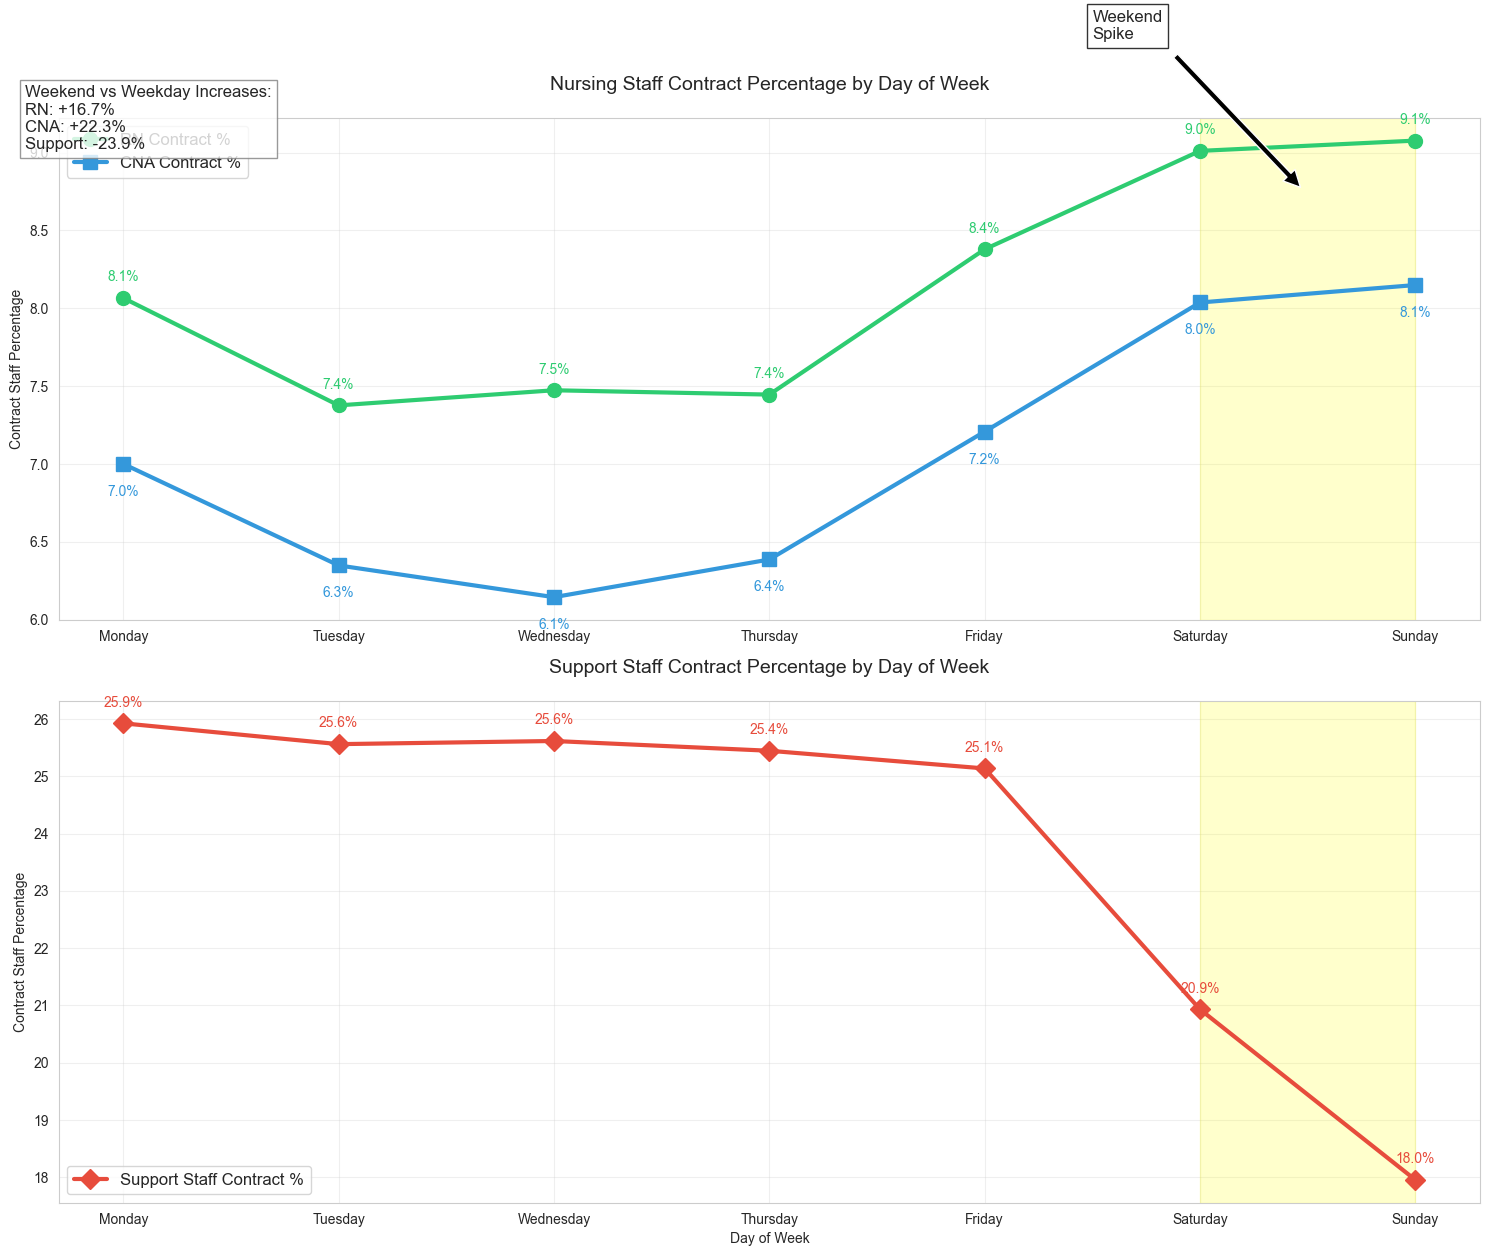

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse data calculations from previous code
# But create two separate plots to better show the patterns

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Day order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
x = np.arange(len(day_order))

# Colors
colors = {'RN': '#2ecc71', 'CNA': '#3498db'}

# Plot 1: Nursing Staff (RN and CNA)
ax1.plot(day_order, 
         rn_daily.set_index('day_of_week').reindex(day_order)['rn_contract_ratio'] * 100,
         marker='o', linewidth=3, markersize=10, color=colors['RN'], label='RN Contract %')
ax1.plot(day_order,
         cna_daily.set_index('day_of_week').reindex(day_order)['cna_contract_ratio'] * 100,
         marker='s', linewidth=3, markersize=10, color=colors['CNA'], label='CNA Contract %')

# Highlight weekend in first plot
ax1.axvspan(5, 6, color='yellow', alpha=0.2)
ax1.set_title('Nursing Staff Contract Percentage by Day of Week', pad=20, fontsize=14)
ax1.set_ylabel('Contract Staff Percentage')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

# Add percentage annotations for RN
for i, val in enumerate(rn_daily.set_index('day_of_week').reindex(day_order)['rn_contract_ratio'] * 100):
    ax1.annotate(f'{val:.1f}%', 
                 xy=(i, val), 
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 va='bottom',
                 color=colors['RN'])

# Add percentage annotations for CNA
for i, val in enumerate(cna_daily.set_index('day_of_week').reindex(day_order)['cna_contract_ratio'] * 100):
    ax1.annotate(f'{val:.1f}%', 
                 xy=(i, val), 
                 xytext=(0, -15),
                 textcoords='offset points',
                 ha='center',
                 va='top',
                 color=colors['CNA'])

# Plot 2: Support Staff
ax2.plot(day_order,
         support_daily.set_index('day_of_week').reindex(day_order)['support_contract_ratio'] * 100,
         marker='D', linewidth=3, markersize=10, color='#e74c3c', label='Support Staff Contract %')

# Highlight weekend in second plot
ax2.axvspan(5, 6, color='yellow', alpha=0.2)
ax2.set_title('Support Staff Contract Percentage by Day of Week', pad=20, fontsize=14)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Contract Staff Percentage')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=12)

# Add percentage annotations for Support Staff
for i, val in enumerate(support_daily.set_index('day_of_week').reindex(day_order)['support_contract_ratio'] * 100):
    ax2.annotate(f'{val:.1f}%', 
                 xy=(i, val), 
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 va='bottom',
                 color='#e74c3c')

# Add weekend increase statistics as text box
stats_text = (f'Weekend vs Weekday Increases:\n'
              f'RN: +{rn_increase:.1f}%\n'
              f'CNA: +{cna_increase:.1f}%\n'
              f'Support: {support_increase:.1f}%')

fig.text(0.02, 0.98, stats_text,
         fontsize=12, ha='left', va='top',
         bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8))

# Adjust layout
plt.tight_layout()

# Add emphasis to weekend spikes with arrows for nursing staff
max_rn_weekday = max(rn_daily[~rn_daily['day_of_week'].isin(['Saturday', 'Sunday'])]['rn_contract_ratio']) * 100
max_rn_weekend = max(rn_daily[rn_daily['day_of_week'].isin(['Saturday', 'Sunday'])]['rn_contract_ratio']) * 100

ax1.annotate('Weekend\nSpike',
             xy=(5.5, (max_rn_weekday + max_rn_weekend)/2),
             xytext=(4.5, (max_rn_weekday + max_rn_weekend)/2 + 1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12,
             bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))


Detailed Census Analysis for Exclusive Contract Days
--------------------------------------------------
• Regular Days Mean Census: 83.7
• Exclusive Contract Days Mean Census: 68.1
• Census Difference: 15.6 residents
• Total Exclusive Contract Days: 23,319
• Facilities with Exclusive Days: 2,202
• p-value < 0.001
• Average census is 18.6% lower on exclusive contract days

Day-of-Week Analysis for Exclusive Contract Days:
  - Sunday: 4,862 days (20.8%)
  - Saturday: 4,546 days (19.5%)
  - Friday: 2,987 days (12.8%)
  - Monday: 2,840 days (12.2%)
  - Thursday: 2,738 days (11.7%)
  - Tuesday: 2,688 days (11.5%)
  - Wednesday: 2,658 days (11.4%)

Facility Size Analysis (for facilities with exclusive-contract days):
  25th - 75th percentile range: 42 to 88 residents


C:\Users\paulo\AppData\Local\Temp\ipykernel_44928\1681166649.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\paulo\AppData\Local\Temp\ipykernel_44928\1681166649.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


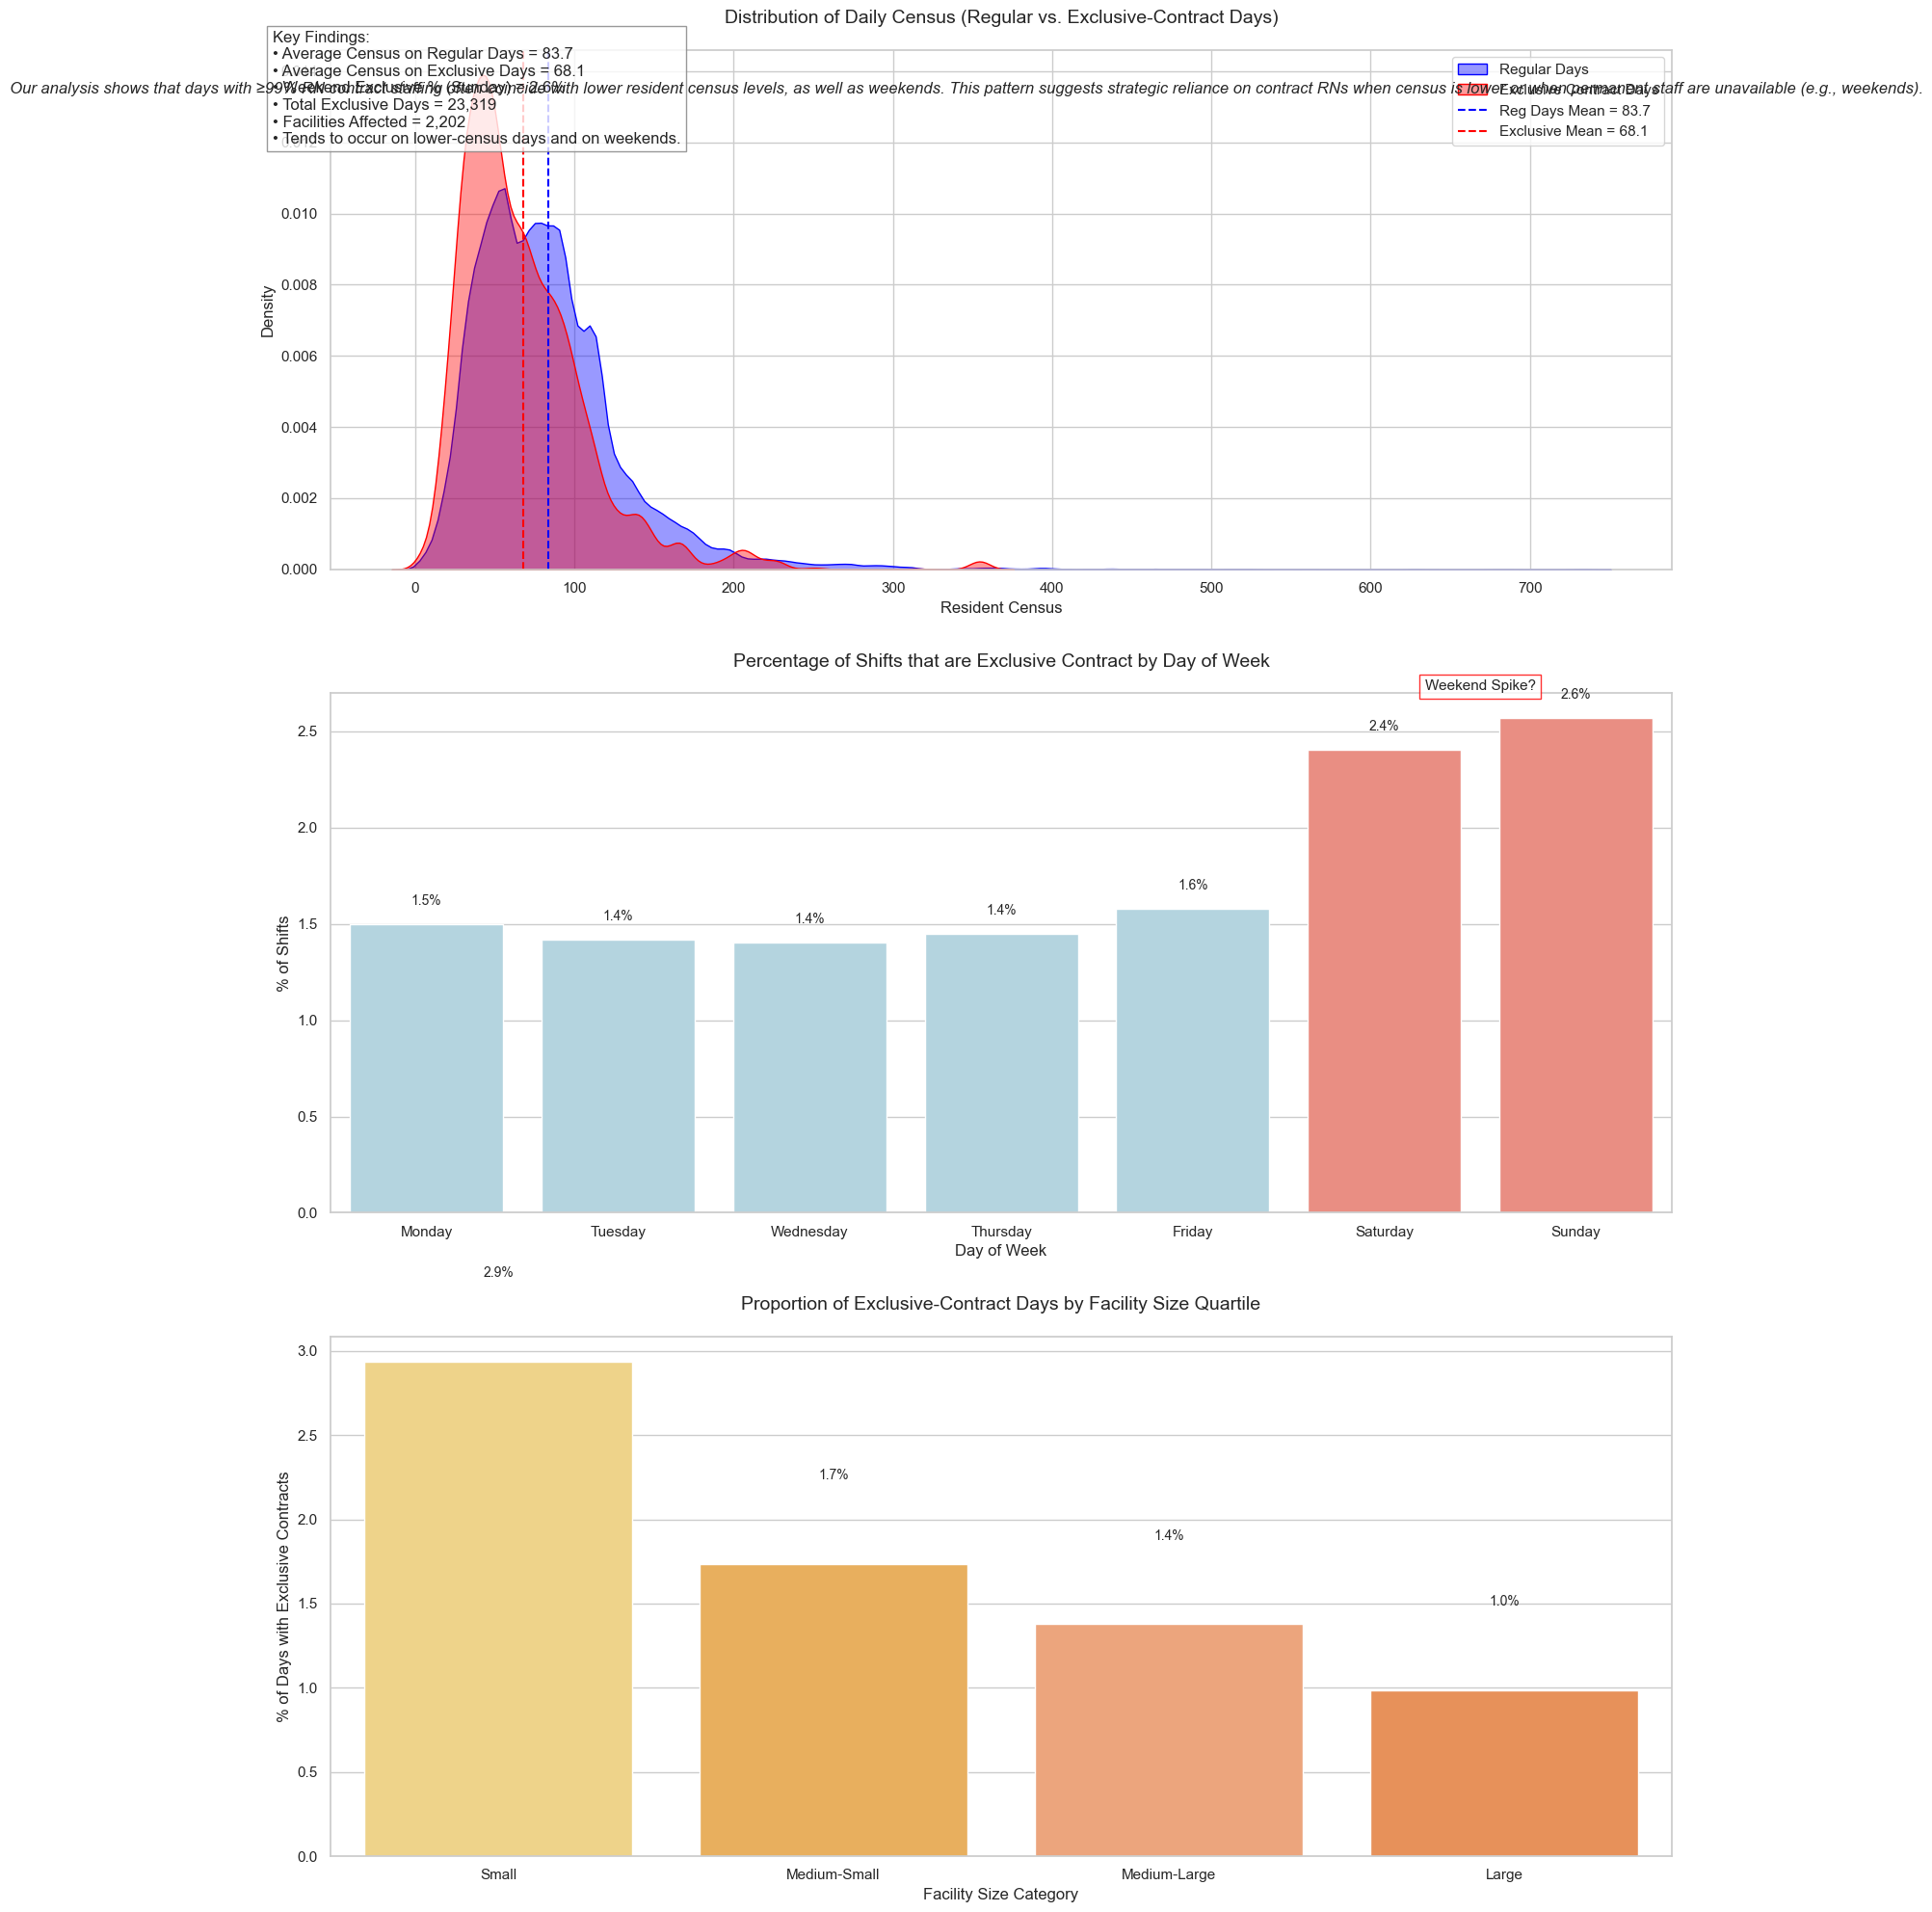


Detailed Pattern Analysis for Exclusive Contract Days
--------------------------------------------------

Weekend vs Weekday Comparison (Exclusive-Contract Days Only):
                 mean  median  count
is_weekend                          
False       67.795054    58.0  13911
True        68.639349    60.0   9408

Facility Size Quartile Impact (Proportion of Exclusive Days):
                   mean  count
size_category                 
Small          0.029366   3641
Medium-Small   0.017360   3641
Medium-Large   0.013793   3641
Large          0.009860   3641


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# -------------------------------------------------------------------------
# 1. Set styling and figure defaults
# -------------------------------------------------------------------------
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 20)
plt.rcParams['font.size'] = 12

# -------------------------------------------------------------------------
# 2. Define constants and compute required columns
# -------------------------------------------------------------------------
EXCLUSIVE_THRESHOLD = 0.99

# Ensure workdate is datetime
df_pbj_nurse['workdate'] = pd.to_datetime(df_pbj_nurse['workdate'])

# Calculate RN contract ratio
df_pbj_nurse['rn_contract_ratio'] = (
    df_pbj_nurse['hrs_rn_ctr'] /
    (df_pbj_nurse['hrs_rn_ctr'] + df_pbj_nurse['hrs_rn_emp'] + 1e-6)
)

# Identify exclusive-contract days for RNs
df_pbj_nurse['is_exclusive_contract'] = df_pbj_nurse['rn_contract_ratio'] >= EXCLUSIVE_THRESHOLD

# Extract day of week and weekend indicator
df_pbj_nurse['day_of_week'] = df_pbj_nurse['workdate'].dt.day_name()
df_pbj_nurse['is_weekend'] = df_pbj_nurse['day_of_week'].isin(['Saturday', 'Sunday'])

# -------------------------------------------------------------------------
# 3. Separate data for "Exclusive Contract Days" vs "Regular Days"
# -------------------------------------------------------------------------
regular_days = df_pbj_nurse.loc[~df_pbj_nurse['is_exclusive_contract'], 'mdscensus']
exclusive_days = df_pbj_nurse.loc[df_pbj_nurse['is_exclusive_contract'], 'mdscensus']

# Basic statistics for means and difference
reg_mean = regular_days.mean()
exc_mean = exclusive_days.mean()
t_stat, p_value = stats.ttest_ind(exclusive_days, regular_days, equal_var=False)

# -------------------------------------------------------------------------
# 4. Print out key stats & differential analyses
# -------------------------------------------------------------------------
print("\nDetailed Census Analysis for Exclusive Contract Days")
print("-" * 50)
print(f"• Regular Days Mean Census: {reg_mean:.1f}")
print(f"• Exclusive Contract Days Mean Census: {exc_mean:.1f}")
print(f"• Census Difference: {reg_mean - exc_mean:.1f} residents")
print(f"• Total Exclusive Contract Days: {df_pbj_nurse['is_exclusive_contract'].sum():,}")
print(f"• Facilities with Exclusive Days: {df_pbj_nurse.loc[df_pbj_nurse['is_exclusive_contract'], 'provnum'].nunique():,}")
print("• p-value < 0.001" if p_value < 0.001 else f"• p-value = {p_value:.4f}")

percent_diff = ((reg_mean - exc_mean) / (reg_mean + 1e-6)) * 100
print(f"• Average census is {percent_diff:.1f}% lower on exclusive contract days")

# -------------------------------------------------------------------------
# 5. Analyze day-of-week frequency for exclusive-contract days
# -------------------------------------------------------------------------
print("\nDay-of-Week Analysis for Exclusive Contract Days:")
day_frequency = df_pbj_nurse.loc[df_pbj_nurse['is_exclusive_contract'], 'day_of_week'].value_counts()
for day, count in day_frequency.items():
    pct = (count / len(exclusive_days)) * 100
    print(f"  - {day}: {count:,} days ({pct:.1f}%)")

# -------------------------------------------------------------------------
# 6. Facility Size Analysis (average census by provnum)
# -------------------------------------------------------------------------
regular_avg_census = df_pbj_nurse.groupby('provnum')['mdscensus'].mean()
exclusive_facilities = df_pbj_nurse.loc[df_pbj_nurse['is_exclusive_contract'], 'provnum'].unique()
exclusive_size_stats = regular_avg_census[regular_avg_census.index.isin(exclusive_facilities)].describe()

print("\nFacility Size Analysis (for facilities with exclusive-contract days):")
print(f"  25th - 75th percentile range: {exclusive_size_stats['25%']:.0f} to {exclusive_size_stats['75%']:.0f} residents")

# -------------------------------------------------------------------------
# 7. Create a 3-plot figure:
#    (1) Overlaid density plot (regular vs. exclusive day census)
#    (2) Day-of-week distribution of exclusive-contract days
#    (3) Proportion of exclusive-contract days by facility-size quartile
# -------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

# -------------------------
# 7.1 Overlaid density plots (Census: Exclusive vs Regular)
# -------------------------
sns.kdeplot(regular_days, fill=True, color='blue', alpha=0.4, label='Regular Days', ax=ax1)
sns.kdeplot(exclusive_days, fill=True, color='red', alpha=0.4, label='Exclusive Contract Days', ax=ax1)

ax1.axvline(reg_mean, color='blue', linestyle='--', label=f'Reg Days Mean = {reg_mean:.1f}')
ax1.axvline(exc_mean, color='red', linestyle='--', label=f'Exclusive Mean = {exc_mean:.1f}')
ax1.set_title('Distribution of Daily Census (Regular vs. Exclusive-Contract Days)', fontsize=14, pad=20)
ax1.set_xlabel('Resident Census')
ax1.set_ylabel('Density')
ax1.legend()

# -------------------------
# 7.2 Day-of-week distribution (percentage of shifts that are exclusive contract)
# -------------------------
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count total shifts and exclusive shifts by day
total_by_day = df_pbj_nurse['day_of_week'].value_counts()
exclusive_by_day = df_pbj_nurse.loc[df_pbj_nurse['is_exclusive_contract'], 'day_of_week'].value_counts()

# Reindex and compute percentages
exclusive_by_day = exclusive_by_day.reindex(day_order, fill_value=0)
total_by_day = total_by_day.reindex(day_order, fill_value=0)
pct_exclusive = (exclusive_by_day / total_by_day) * 100

# Manually define colors for weekdays vs weekends
colors = ['lightblue' if d not in ['Saturday','Sunday'] else 'salmon' for d in day_order]

sns.barplot(
    x=day_order, y=pct_exclusive.values, ax=ax2, 
    palette=colors
)
ax2.set_title('Percentage of Shifts that are Exclusive Contract by Day of Week', fontsize=14, pad=20)
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('% of Shifts')

for i, v in enumerate(pct_exclusive):
    ax2.text(i, v + 0.1, f'{v:.1f}%', ha='center', fontsize=10)

# Annotate weekend
ax2.text(
    5.5, ax2.get_ylim()[1], 'Weekend Spike?', ha='center', va='bottom',
    fontsize=11, bbox=dict(facecolor='white', edgecolor='red', alpha=0.8)
)

# -------------------------
# 7.3 Facility-size vs. exclusive-contract proportion
# -------------------------
facility_stats = df_pbj_nurse.groupby('provnum', observed=True).agg({
    'mdscensus': 'mean',
    'is_exclusive_contract': 'mean'
}).reset_index()

# Define quartiles to create 4 size categories
facility_stats['size_category'] = pd.qcut(
    facility_stats['mdscensus'],
    q=4,
    labels=['Small', 'Medium-Small', 'Medium-Large', 'Large']
)

size_exclusive = (
    facility_stats
    .groupby('size_category', observed=True)['is_exclusive_contract']
    .mean() * 100
)

# A simple four-color palette
quartile_colors = ["#FFDA79", "#FFB347", "#FFA06A", "#FF8C42"]

sns.barplot(
    x=size_exclusive.index, 
    y=size_exclusive.values, 
    ax=ax3, 
    palette=quartile_colors
)
ax3.set_title('Proportion of Exclusive-Contract Days by Facility Size Quartile', fontsize=14, pad=20)
ax3.set_xlabel('Facility Size Category')
ax3.set_ylabel('% of Days with Exclusive Contracts')

for i, v in enumerate(size_exclusive):
    ax3.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=10)

# -------------------------------------------------------------------------
# 8. Add textual annotations to the figure
# -------------------------------------------------------------------------
stats_text = (
    "Key Findings:\n"
    f"• Average Census on Regular Days = {reg_mean:.1f}\n"
    f"• Average Census on Exclusive Days = {exc_mean:.1f}\n"
    f"• Weekend Exclusive % (Sunday) = {pct_exclusive['Sunday']:.1f}%\n"
    f"• Total Exclusive Days = {df_pbj_nurse['is_exclusive_contract'].sum():,}\n"
    f"• Facilities Affected = {df_pbj_nurse.loc[df_pbj_nurse['is_exclusive_contract'], 'provnum'].nunique():,}\n"
    "• Tends to occur on lower-census days and on weekends."
)

fig.text(
    0.02, 0.98, stats_text, fontsize=12, va='top',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8)
)

narrative = (
    "Our analysis shows that days with ≥99% RN contract staffing often coincide "
    "with lower resident census levels, as well as weekends. This pattern "
    "suggests strategic reliance on contract RNs when census is lower or when "
    "permanent staff are unavailable (e.g., weekends)."
)
fig.text(0.5, 0.95, narrative, fontsize=12, ha='center', va='center', style='italic')

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 9. Additional Weekend vs Weekday Stats
# -------------------------------------------------------------------------
print("\nDetailed Pattern Analysis for Exclusive Contract Days")
print("-" * 50)

weekend_stats = (
    df_pbj_nurse[df_pbj_nurse['is_exclusive_contract']]
    .groupby('is_weekend', observed=True)['mdscensus']
    .agg(['mean', 'median', 'count'])
)
print("\nWeekend vs Weekday Comparison (Exclusive-Contract Days Only):")
print(weekend_stats)

size_stats = (
    facility_stats
    .groupby('size_category', observed=True)['is_exclusive_contract']
    .agg(['mean', 'count'])
)
print("\nFacility Size Quartile Impact (Proportion of Exclusive Days):")
print(size_stats)


C:\Users\paulo\AppData\Local\Temp\ipykernel_44928\2072847743.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=roles, y=ratios, palette=['#4878CF', '#6ACC65', '#FFA843'])


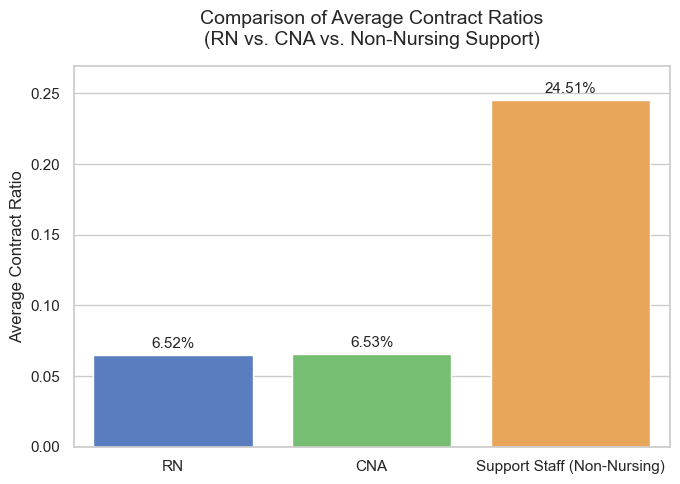

Support Staff (Non-Nursing) Contract Usage Analysis
---------------------------------------------------
• Average RN Contract Ratio: 6.52%
• Average CNA Contract Ratio: 6.53%
• Average Non-Nursing Support Contract Ratio: 24.51%

Insight: Non-nursing support roles show significantly higher contract usage than RNs and CNAs.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# 1. Calculate contract ratios for each category: RNs, CNAs, and Non-Nursing Support
# ------------------------------------------------------------------------------

# -- RN & CNA ratios from df_pbj_nurse --

# RN contract ratio
df_pbj_nurse['rn_contract_ratio'] = (
    df_pbj_nurse['hrs_rn_ctr'] /
    (df_pbj_nurse['hrs_rn_ctr'] + df_pbj_nurse['hrs_rn_emp'] + 1e-6)
)

# CNA contract ratio
df_pbj_nurse['cna_contract_ratio'] = (
    df_pbj_nurse['hrs_cna_ctr'] /
    (df_pbj_nurse['hrs_cna_ctr'] + df_pbj_nurse['hrs_cna_emp'] + 1e-6)
)

# Compute global RN & CNA contract ratio averages
avg_rn_ratio = df_pbj_nurse['rn_contract_ratio'].mean()
avg_cna_ratio = df_pbj_nurse['cna_contract_ratio'].mean()

# -- Non-Nursing Support Staff ratio from df_pbj_non_nurse --
# We'll sum all employee hours for non-nursing roles, then all contract hours, and compute a single ratio.
# (You can expand or narrow the roles to include exactly what you need.)

# Identify columns that end in "_emp" or "_ctr" and exclude certain roles if desired.
emp_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_emp')]
ctr_cols = [col for col in df_pbj_non_nurse.columns if col.endswith('_ctr')]

# Sum across all employee hours
df_pbj_non_nurse['non_nurse_emp_sum'] = df_pbj_non_nurse[emp_cols].sum(axis=1)
# Sum across all contract hours
df_pbj_non_nurse['non_nurse_ctr_sum'] = df_pbj_non_nurse[ctr_cols].sum(axis=1)

# Calculate daily ratio for non-nursing staff
df_pbj_non_nurse['non_nurse_contract_ratio'] = (
    df_pbj_non_nurse['non_nurse_ctr_sum'] /
    (df_pbj_non_nurse['non_nurse_ctr_sum'] + df_pbj_non_nurse['non_nurse_emp_sum'] + 1e-6)
)

# Compute global average ratio for non-nursing support staff
avg_non_nurse_ratio = df_pbj_non_nurse['non_nurse_contract_ratio'].mean()

# ------------------------------------------------------------------------------
# 2. Create a simple bar chart comparing the three averages
# ------------------------------------------------------------------------------
roles = ['RN', 'CNA', 'Support Staff (Non-Nursing)']
ratios = [avg_rn_ratio, avg_cna_ratio, avg_non_nurse_ratio]

plt.figure(figsize=(7,5))
sns.barplot(x=roles, y=ratios, palette=['#4878CF', '#6ACC65', '#FFA843'])

for i, v in enumerate(ratios):
    plt.text(i, v+0.005, f"{v:.2%}", ha='center', fontsize=11)

plt.ylim(0, max(ratios)*1.1)
plt.title("Comparison of Average Contract Ratios\n(RN vs. CNA vs. Non-Nursing Support)", fontsize=14, pad=15)
plt.ylabel("Average Contract Ratio")
plt.xlabel("")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 3. Print a short narrative
# ------------------------------------------------------------------------------
print("Support Staff (Non-Nursing) Contract Usage Analysis")
print("---------------------------------------------------")
print(f"• Average RN Contract Ratio: {avg_rn_ratio:.2%}")
print(f"• Average CNA Contract Ratio: {avg_cna_ratio:.2%}")
print(f"• Average Non-Nursing Support Contract Ratio: {avg_non_nurse_ratio:.2%}\n")

if avg_non_nurse_ratio > avg_rn_ratio and avg_non_nurse_ratio > avg_cna_ratio:
    print("Insight: Non-nursing support roles show significantly higher contract usage than RNs and CNAs.")
else:
    print("Insight: Non-nursing support contract usage is not significantly higher than nursing roles in this dataset.")
